In [1]:
import polars as pl

Let's read in our csv which has game info from 1899-2024

In [2]:
df = pl.read_csv("data/allseasonsgameinfo.csv", infer_schema_length=1000000)

## Data Prep

In [3]:
print(df.shape)
df.head()

(212555, 43)


gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
str,str,str,str,i64,i64,str,str,i64,i64,bool,bool,i64,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64
"""LS3189904140""","""CHN""","""LS3""","""LOU03""",18990414,0,"""0:00PM""","""day""",null,null,false,null,113,11500,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""burno101""","""warna901""",null,null,null,null,"""grifc101""","""cunnb103""",null,"""regular""",15,1,"""CHN""","""LS3""","""y""","""both""","""y""","""y""",null,1899
"""PHI189904140""","""WSN""","""PHI""","""PHI09""",18990414,0,"""0:00PM""","""day""",null,null,false,null,120,12000,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""huntj901""","""connt901""",null,null,null,null,"""piatw101""","""killf101""",null,"""regular""",5,6,"""PHI""","""WSN""","""y""","""both""","""y""","""y""",null,1899
"""BLN189904150""","""NY1""","""BLN""","""BAL07""",18990415,0,"""0:00PM""","""day""",null,null,false,null,130,3912,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""emslb101""","""bettw901""",null,null,null,null,"""kitsf101""","""dohee101""",null,"""regular""",3,5,"""BLN""","""NY1""","""y""","""both""","""y""","""y""",null,1899
"""BRO189904150""","""BSN""","""BRO""","""NYC12""",18990415,0,"""0:00PM""","""day""",null,null,false,null,120,20167,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""andre101""","""gaffj801""",null,null,null,null,"""nichk101""","""kennb101""",null,"""regular""",1,0,"""BSN""","""BRO""","""y""","""both""","""y""","""y""",null,1899
"""CIN189904150""","""PIT""","""CIN""","""CIN05""",18990415,0,"""0:00PM""","""day""",null,null,false,null,130,10000,"""unknown""","""unknown""","""unknown""","""0""","""unknown""","""-1""",null,null,null,"""sware101""","""warna901""",null,null,null,null,"""tannj101""","""hawlp101""",null,"""regular""",5,2,"""PIT""","""CIN""","""y""","""both""","""y""","""y""",null,1899


In [4]:
df.describe()

statistic,gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season
str,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,f64
"""count""","""212555""","""212555""","""212555""","""212555""",212555.0,201787.0,"""113106""","""212545""",10836.0,10640.0,212545.0,252.0,211985.0,212505.0,"""212541""","""212541""","""212543""","""212545""","""212544""","""212543""","""52253""","""38""",198.0,"""212553""","""212497""","""211603""","""211603""","""12503""","""12309""","""211720""","""211720""","""76759""","""212555""",212555.0,212555.0,"""211748""","""211748""","""212545""","""212545""","""212545""","""212545""","""198998""",212555.0
"""null_count""","""0""","""0""","""0""","""0""",0.0,10768.0,"""99449""","""10""",201719.0,201915.0,10.0,212303.0,570.0,50.0,"""14""","""14""","""12""","""10""","""11""","""12""","""160302""","""212517""",212357.0,"""2""","""58""","""952""","""952""","""200052""","""200246""","""835""","""835""","""135796""","""0""",0.0,0.0,"""807""","""807""","""10""","""10""","""10""","""10""","""13557""",0.0
"""mean""",null,null,null,null,1.9718e7,0.215445,null,null,8.956995,2.0,0.294178,1.0,152.401269,18996.905278,null,null,null,null,null,null,null,null,1.9803e7,null,null,null,null,null,null,null,null,null,null,4.337164,4.492113,null,null,null,null,null,null,null,1971.714497
"""std""",null,null,null,null,356467.561215,0.559184,null,null,0.29107,0.0,null,null,38.295844,14639.194472,null,null,null,null,null,null,null,null,265316.503551,null,null,null,null,null,null,null,null,null,null,3.168415,3.105077,null,null,null,null,null,null,null,35.647724
"""min""","""ALS193307060""","""ALS""","""ALS""","""ANA01""",1.8990414e7,0.0,"""00:00AM""","""day""",6.0,2.0,0.0,1.0,0.0,0.0,"""damp""","""drizzle""","""cloudy""","""0""","""fromcf""","""-1""",""" ""","""Y""",1.9131002e7,"""(unknown)""","""(none)""","""(none)""","""(none)""","""(none)""","""(none)""","""aardd001""","""aardd001""","""aardd001""","""allstar""",0.0,0.0,"""ALS""","""ALS""","""y""","""both""","""y""","""y""","""d""",1899.0
"""25%""",null,null,null,null,1.9430527e7,0.0,null,null,9.0,2.0,null,null,128.0,6000.0,null,null,null,null,null,null,null,null,1.9580729e7,null,null,null,null,null,null,null,null,null,null,2.0,2.0,null,null,null,null,null,null,null,1943.0
"""50%""",null,null,null,null,1.9780517e7,0.0,null,null,9.0,2.0,null,null,153.0,16748.0,null,null,null,null,null,null,null,null,1.9780803e7,null,null,null,null,null,null,null,null,null,null,4.0,4.0,null,null,null,null,null,null,null,1978.0
"""75%""",null,null,null,null,2.0020903e7,0.0,null,null,9.0,2.0,null,null,176.0,30200.0,null,null,null,null,null,null,null,null,2.0041003e7,null,null,null,null,null,null,null,null,null,null,6.0,6.0,null,null,null,null,null,null,null,2002.0
"""max""","""WSN189910140""","""WSN""","""WSN""","""WNY01""",2.024103e7,3.0,"""9:59PM""","""night""",10.0,2.0,1.0,1.0,486.0,92706.0,"""wet""","""unknown""","""unknown""","""unknown""","""unknown""","""unknown""","""zibed701""","""Y""",2.0240828e7,"""zirbl901""","""zirbl901""","""zuccr901""","""zirbl901""","""younl901""","""zivid901""","""zycht001""","""zycht001""","""zycht001""","""worldseries""",30.0,29.0,"""WSN""","""WSN""","""y""","""both""","""y""","""y""","""y""",2024.0


We need to filter the data so that no years before 1998 are included.

In [5]:
df = df.filter(pl.col("season") >= 1998)
print(df.shape)

(65043, 43)


In [6]:
# sanity check

print(df.select(pl.col("season").min()).item())
print(df.select(pl.col("season").max()).item())

1998
2024


Our data preparation will be very similar to the single season ELO preparation, but we need to account for multiple seasons in our dataset.


We still need the games sorted by date so let's create our date column. Because we saw earlier that some of the starttimes are null, we'll go with a different approach.

In [7]:
df = df.with_columns(
    pl.col("date")
    .cast(pl.String)
    .str.strptime(pl.Date, format="%Y%m%d")
    .alias("game_datetime")
)

Since I saw earlier that some of the number values are null. I want to make sure that they aren't null when there was more than one game between the same teams on the same day.

In [8]:
result = (
    df.group_by(["visteam", "hometeam", "game_datetime"], maintain_order=True)
    .agg(
        [
            pl.col("number").is_null().any().alias("has_null"),
            pl.count().alias("group_size"),
        ]
    )
    .filter((pl.col("group_size") > 1) & (pl.col("has_null")))
)

/var/folders/np/wclmj0n91716_dhv631n202h0000gn/T/ipykernel_32842/439727834.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("group_size"),


In [9]:
result

visteam,hometeam,game_datetime,has_null,group_size
str,str,date,bool,u32


Since this is empty, I think we can fill the number cols nulls with 0.

In [10]:
df.head()

gid,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,htbf,timeofgame,attendance,fieldcond,precip,sky,temp,winddir,windspeed,oscorer,forfeit,suspend,umphome,ump1b,ump2b,ump3b,umplf,umprf,wp,lp,save,gametype,vruns,hruns,wteam,lteam,line,batteries,lineups,box,pbp,season,game_datetime
str,str,str,str,i64,i64,str,str,i64,i64,bool,bool,i64,i64,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,i64,date
"""ARI199803310""","""COL""","""ARI""","""PHO01""",19980331,0,"""8:22PM""","""night""",null,null,false,null,170,47484,"""dry""","""none""","""night""","""57""","""ltor""","""2""",null,null,null,"""quicj901""","""demud901""","""darlg901""","""poncl901""",null,null,"""kiled001""","""benea001""",null,"""regular""",9,2,"""COL""","""ARI""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""ATL199803310""","""MIL""","""ATL""","""ATL02""",19980331,0,"""4:11PM""","""day""",null,null,false,null,159,42891,"""dry""","""none""","""overcast""","""85""","""ltor""","""9""",null,null,null,"""froeb901""","""grege901""","""hirsm901""","""vanol901""",null,null,"""ligtk001""","""wickb001""",null,"""regular""",1,2,"""ATL""","""MIL""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""BAL199803310""","""KCA""","""BAL""","""BAL12""",19980331,0,"""3:12PM""","""day""",null,null,true,null,158,46820,"""dry""","""none""","""sunny""","""91""","""ltor""","""13""",null,null,null,"""mckej901""","""clara901""","""joycj901""","""craft901""",null,null,"""belct001""","""mussm001""","""montj002""","""regular""",4,1,"""KCA""","""BAL""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""CIN199803310""","""SDN""","""CIN""","""CIN08""",19980331,0,"""2:06PM""","""day""",null,null,false,null,168,54578,"""dry""","""none""","""cloudy""","""75""","""ltor""","""12""",null,null,null,"""marsr901""","""bonig901""","""hohnb901""","""herna901""",null,null,"""browk001""","""remlm001""",null,"""regular""",10,2,"""SDN""","""CIN""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31
"""FLO199803310""","""CHN""","""FLO""","""MIA01""",19980331,0,"""4:36PM""","""day""",null,null,false,null,188,41126,"""dry""","""none""","""cloudy""","""84""","""tocf""","""8""",null,null,null,"""pullf901""","""willc901""","""rapue901""","""drecb901""",null,null,"""hernl003""","""tapak001""",null,"""regular""",6,11,"""FLO""","""CHN""","""y""","""both""","""y""","""y""","""y""",1998,1998-03-31


In [11]:
df = df.with_columns(
    pl.when(pl.col("number").is_null())
    .then(0)
    .otherwise(pl.col("number"))
    .alias("number")
)

In [12]:
df = df.sort(by=["game_datetime", "number"])

In [13]:
# sanity check
min_date = df.select(pl.col("game_datetime").min()).item()
print(min_date, df.head())

max_date = df.select(pl.col("game_datetime").max()).item()
print(max_date, df.tail())

1998-03-31 shape: (5, 44)
┌──────────────┬─────────┬──────────┬───────┬───┬─────┬─────┬────────┬───────────────┐
│ gid          ┆ visteam ┆ hometeam ┆ site  ┆ … ┆ box ┆ pbp ┆ season ┆ game_datetime │
│ ---          ┆ ---     ┆ ---      ┆ ---   ┆   ┆ --- ┆ --- ┆ ---    ┆ ---           │
│ str          ┆ str     ┆ str      ┆ str   ┆   ┆ str ┆ str ┆ i64    ┆ date          │
╞══════════════╪═════════╪══════════╪═══════╪═══╪═════╪═════╪════════╪═══════════════╡
│ ATL199803310 ┆ MIL     ┆ ATL      ┆ ATL02 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ BAL199803310 ┆ KCA     ┆ BAL      ┆ BAL12 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ CIN199803310 ┆ SDN     ┆ CIN      ┆ CIN08 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ FLO199803310 ┆ CHN     ┆ FLO      ┆ MIA01 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
│ HOU199803310 ┆ SFN     ┆ HOU      ┆ HOU02 ┆ … ┆ y   ┆ y   ┆ 1998   ┆ 1998-03-31    │
└──────────────┴─────────┴──────────┴───────┴───┴─────┴─────┴────────┴───────────────┘
2024-10-30 shape:

In [14]:
print(df.shape)
df = df.filter(pl.col("gametype") == "regular")
print(df.shape)

(65043, 44)
(64056, 44)


In [15]:
keep_cols = [
    "game_datetime",
    "visteam",
    "hometeam",
    "wteam",
    "lteam",
    "vruns",
    "hruns",
    "season",
    # "gametype",
]

In [16]:
df = df.select(keep_cols)

In [17]:
df.select(pl.col("hometeam").unique()).to_series().to_list()

['CHN',
 'MON',
 'DET',
 'BOS',
 'FLO',
 'CHA',
 'ARI',
 'BAL',
 'CIN',
 'PHI',
 'LAN',
 'WAS',
 'MIN',
 'CLE',
 'NYA',
 'TBA',
 'HOU',
 'ATL',
 'MIL',
 'NYN',
 'PIT',
 'KCA',
 'TEX',
 'COL',
 'ANA',
 'SLN',
 'MIA',
 'SFN',
 'TOR',
 'SEA',
 'OAK',
 'SDN']

In [18]:
team_name_corrections = {
    "NYA": "NYY",
    "CHA": "CHW",
    "CHN": "CHC",
    "LAN": "LAD",
    "KCA": "KCR",
    "NYM": "NYM",
    "SFN": "SFG",
    "SDN": "SDP",
    "SLN": "STL",
    "TBA": "TBR",
    "FLO": "MIA",  # team renamed
    "MON": "WAS",  # team moved
}

In [19]:
df = df.with_columns(
    [
        pl.col("hometeam").map_elements(
            lambda x: team_name_corrections.get(x, x), return_dtype=pl.String
        ),
        pl.col("visteam").map_elements(
            lambda x: team_name_corrections.get(x, x), return_dtype=pl.String
        ),
    ]
)

In [20]:
unique_vis_teams = df.select(pl.col("visteam").unique()).to_series().to_list()
unique_home_teams = df.select(pl.col("hometeam").unique()).to_series().to_list()
teams = set(unique_vis_teams) | set(unique_home_teams)

In [21]:
assert len(teams) == 30, f"Expected 30 teams, but found {len(teams)}"

In [22]:
df.head()

game_datetime,visteam,hometeam,wteam,lteam,vruns,hruns,season
date,str,str,str,str,i64,i64,i64
1998-03-31,"""MIL""","""ATL""","""ATL""","""MIL""",1,2,1998
1998-03-31,"""KCR""","""BAL""","""KCA""","""BAL""",4,1,1998
1998-03-31,"""SDP""","""CIN""","""SDN""","""CIN""",10,2,1998
1998-03-31,"""CHC""","""MIA""","""FLO""","""CHN""",6,11,1998
1998-03-31,"""SFG""","""HOU""","""SFN""","""HOU""",9,4,1998


## Calculate ELO Ratings with no hyperparameter tuning

In [23]:
import math
from collections import defaultdict

In [24]:
BASELINE_ELO = 1500  # starting elo for all teams, all teams start equal, editing this mostly affects the scale, not rankings
CARRYOVER = 0.75  # what fraction of previous season's rating to carry over, lowering values means more regression between seasons
K_BASE = 5  # base K-factor, controls how much elo changes per game, higher means elo reacts more quickly to results
HFA = 3  # home field advantage, elo points added to the home team to account for home field advantage
MOV_CAP = 2.5  # margin of victory cap, caps the impact of blowouts, too high and blowouts overly influence elo

In [25]:
def expected_score(elo_a, elo_b):
    return 1.0 / (1.0 + 10 ** ((elo_b - elo_a) / 400.0))

In [26]:
def mov_multiplier(rd, elo_diff, c_max=MOV_CAP):
    rd = max(0.0, float(rd))
    base = math.log(1 + rd)
    fudge = 2.2 / (abs(elo_diff) * 0.001 + 2.2)
    mult = base * fudge
    return min(mult, c_max)

In [27]:
df = df.sort(by=["game_datetime"])

In [28]:
teams = df.select(pl.col("hometeam").unique()).to_series().to_list()

In [29]:
ratings = {team: BASELINE_ELO for team in teams}

In [30]:
games_played = defaultdict(int)
games_won = defaultdict(int)

In [31]:
rating_history = []

In [32]:
current_season = None

In [33]:
for row in df.iter_rows(named=True):
    season = int(row["season"])
    # for the start of the first season
    if current_season is None:
        current_season = season
    # When season changes, apply preseason regression once before first game of the new season
    if season != current_season:
        for team in ratings:
            ratings[team] = ratings[team] * CARRYOVER + BASELINE_ELO * (1.0 - CARRYOVER)
        games_played = defaultdict(int)  # reset games played for new season
        current_season = season
    home_team, away_team = row["hometeam"], row["visteam"]
    hruns, vruns = int(row["hruns"]), int(row["vruns"])

    pre_home_elo, pre_away_elo = ratings[home_team], ratings[away_team]

    home_adj_elo = pre_home_elo + HFA
    exp_home = expected_score(home_adj_elo, pre_away_elo)

    if hruns > vruns:
        actual_home = 1.0
        rd = hruns - vruns
    else:
        actual_home = 0.0
        rd = vruns - hruns

    mult = mov_multiplier(rd, pre_home_elo - pre_away_elo)

    # Optional: dynamic K based on games_played
    # per-team K could be: K_base * (1 + early_boost / (games_played[team] + early_decay))
    # For now we'll keep base K.
    K = (
        K_BASE
        * (1 + 5 / (games_played[home_team] + 1))
        * (1 + 5 / (games_played[away_team] + 1))
    )
    change_home = K * mult * (actual_home - exp_home)
    change_away = -change_home

    ratings[home_team] += change_home
    ratings[away_team] += change_away

    # increment games played (for future K adjustments if desired)
    games_played[home_team] += 1
    games_played[away_team] += 1
    if hruns > vruns:
        games_won[home_team] += 1
    else:
        games_won[away_team] += 1
    rating_history.append(
        {
            "game_datetime": row["game_datetime"],
            "season": season,
            "home_team": home_team,
            "away_team": away_team,
            "pre_home_elo": pre_home_elo,
            "pre_away_elo": pre_away_elo,
            "exp_home": exp_home,
            "hruns": hruns,
            "vruns": vruns,
            "rd": rd,
            "mov_mult": mult,
            "change_home": change_home,
            "post_home_elo": ratings[home_team],
            "post_away_elo": ratings[away_team],
        }
    )

# Hyperparameter tuning

In [34]:
from itertools import product

from sklearn.metrics import log_loss

In [35]:
K_BASE_grid = [3, 5, 7, 10]
CARRYOVER_grid = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
HFA_grid = [0, 3, 5, 10]
MOV_CAP_grid = [1.5, 2.5, 3.5, 5]

In [36]:
param_grid = list(product(K_BASE_grid, CARRYOVER_grid, HFA_grid, MOV_CAP_grid))

In [37]:
train_df = df.filter(pl.col("season") < 2022)
val_df = df.filter(pl.col("season") >= 2022)

In [38]:
def expected_score(elo_a, elo_b):
    return 1.0 / (1.0 + 10 ** ((elo_b - elo_a) / 400.0))

In [39]:
def mov_multiplier(rd, elo_diff, c_max=MOV_CAP):
    rd = max(0.0, float(rd))
    base = math.log(1 + rd)
    fudge = 2.2 / (abs(elo_diff) * 0.001 + 2.2)
    mult = base * fudge
    return min(mult, c_max)

In [40]:
def run_elo(df, K_BASE, CARRYOVER, HFA, MOV_CAP, initial_ratings=None):
    ratings = (
        initial_ratings.copy()
        if initial_ratings is not None
        else {team: 1500 for team in teams}
    )
    current_season = None
    results = []
    games_played = defaultdict(int)
    for row in df.iter_rows(named=True):
        season = int(row["season"])
        if current_season is None:
            current_season = season
        if season != current_season:
            for team in ratings:
                ratings[team] = ratings[team] * CARRYOVER + 1500 * (1.0 - CARRYOVER)
            games_played = defaultdict(int)
            current_season = season
        home_team, away_team = row["hometeam"], row["visteam"]
        hruns, vruns = int(row["hruns"]), int(row["vruns"])
        pre_home_elo, pre_away_elo = ratings[home_team], ratings[away_team]
        home_adj_elo = pre_home_elo + HFA
        exp_home = expected_score(home_adj_elo, pre_away_elo)
        actual_home = 1.0 if hruns > vruns else 0.0
        rd = abs(hruns - vruns)
        mult = mov_multiplier(rd, pre_home_elo - pre_away_elo, MOV_CAP)
        K = (
            K_BASE
            * (1 + 5 / (games_played[home_team] + 1))
            * (1 + 5 / (games_played[away_team] + 1))
        )
        change_home = K * mult * (actual_home - exp_home)
        ratings[home_team] += change_home
        ratings[away_team] -= change_home
        games_played[home_team] += 1
        games_played[away_team] += 1
        results.append({"exp_home": exp_home, "actual_home": actual_home})
    return results, ratings

In [41]:
best_logloss = float("inf")
best_params = None

In [42]:
for K_BASE, CARRYOVER, HFA, MOV_CAP in param_grid:
    # Run on train, get final ratings
    train_preds, end_train_ratings = run_elo(train_df, K_BASE, CARRYOVER, HFA, MOV_CAP)
    # Run on validation, initialized with end-of-train ratings
    val_preds, _ = run_elo(
        val_df, K_BASE, CARRYOVER, HFA, MOV_CAP, initial_ratings=end_train_ratings
    )
    y_true = [x["actual_home"] for x in val_preds]
    y_pred = [x["exp_home"] for x in val_preds]
    loss = log_loss(y_true, y_pred, labels=[0, 1])
    print(
        f"K_BASE={K_BASE}, CARRYOVER={CARRYOVER}, HFA={HFA}, MOV_CAP={MOV_CAP} => LogLoss={loss:.4f}"
    )
    if loss < best_logloss:
        best_logloss = loss
        best_params = (K_BASE, CARRYOVER, HFA, MOV_CAP)

print("Best params:", best_params, "with LogLoss:", best_logloss)

K_BASE=3, CARRYOVER=0.5, HFA=0, MOV_CAP=1.5 => LogLoss=0.6884
K_BASE=3, CARRYOVER=0.5, HFA=0, MOV_CAP=2.5 => LogLoss=0.6910
K_BASE=3, CARRYOVER=0.5, HFA=0, MOV_CAP=3.5 => LogLoss=0.6912
K_BASE=3, CARRYOVER=0.5, HFA=0, MOV_CAP=5 => LogLoss=0.6912
K_BASE=3, CARRYOVER=0.5, HFA=3, MOV_CAP=1.5 => LogLoss=0.6880
K_BASE=3, CARRYOVER=0.5, HFA=3, MOV_CAP=2.5 => LogLoss=0.6906
K_BASE=3, CARRYOVER=0.5, HFA=3, MOV_CAP=3.5 => LogLoss=0.6907
K_BASE=3, CARRYOVER=0.5, HFA=3, MOV_CAP=5 => LogLoss=0.6907
K_BASE=3, CARRYOVER=0.5, HFA=5, MOV_CAP=1.5 => LogLoss=0.6878
K_BASE=3, CARRYOVER=0.5, HFA=5, MOV_CAP=2.5 => LogLoss=0.6904
K_BASE=3, CARRYOVER=0.5, HFA=5, MOV_CAP=3.5 => LogLoss=0.6905
K_BASE=3, CARRYOVER=0.5, HFA=5, MOV_CAP=5 => LogLoss=0.6905
K_BASE=3, CARRYOVER=0.5, HFA=10, MOV_CAP=1.5 => LogLoss=0.6874
K_BASE=3, CARRYOVER=0.5, HFA=10, MOV_CAP=2.5 => LogLoss=0.6900
K_BASE=3, CARRYOVER=0.5, HFA=10, MOV_CAP=3.5 => LogLoss=0.6901
K_BASE=3, CARRYOVER=0.5, HFA=10, MOV_CAP=5 => LogLoss=0.6901
K_BASE=3, CA

## Evaluation

In [43]:
elo_df = pl.DataFrame(rating_history)


In [44]:
elo_df.head()

game_datetime,season,home_team,away_team,pre_home_elo,pre_away_elo,exp_home,hruns,vruns,rd,mov_mult,change_home,post_home_elo,post_away_elo
date,i64,str,str,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64
1998-03-31,1998,"""ATL""","""MIL""",1500.0,1500.0,0.504317,2,1,1,0.693147,61.844599,1561.844599,1438.155401
1998-03-31,1998,"""BAL""","""KCR""",1500.0,1500.0,0.504317,1,4,3,1.386294,-125.843786,1374.156214,1625.843786
1998-03-31,1998,"""CIN""","""SDP""",1500.0,1500.0,0.504317,2,10,8,2.197225,-199.457682,1300.542318,1699.457682
1998-03-31,1998,"""MIA""","""CHC""",1500.0,1500.0,0.504317,11,6,5,1.791759,159.86597,1659.86597,1340.13403
1998-03-31,1998,"""HOU""","""SFG""",1500.0,1500.0,0.504317,4,9,5,1.791759,-162.650734,1337.349266,1662.650734


In [45]:
team_history_df = (
    elo_df.select(
        [
            pl.col("game_datetime"),
            pl.col("home_team").alias("team"),
            pl.col("post_home_elo").alias("elo"),
        ]
    )
    .vstack(
        elo_df.select(
            [
                pl.col("game_datetime"),
                pl.col("away_team").alias("team"),
                pl.col("post_away_elo").alias("elo"),
            ]
        )
    )
    .sort("game_datetime")
)

In [46]:
import matplotlib.pyplot as plt

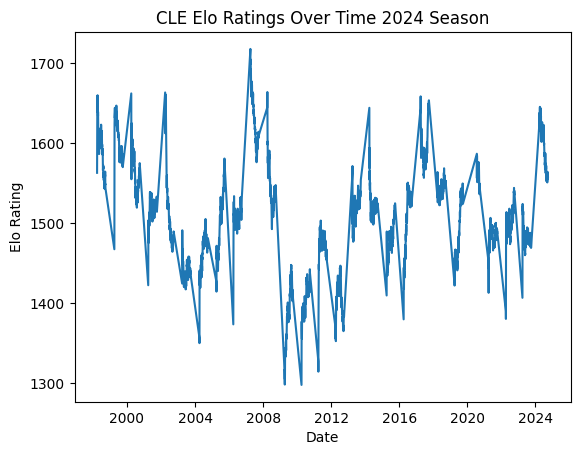

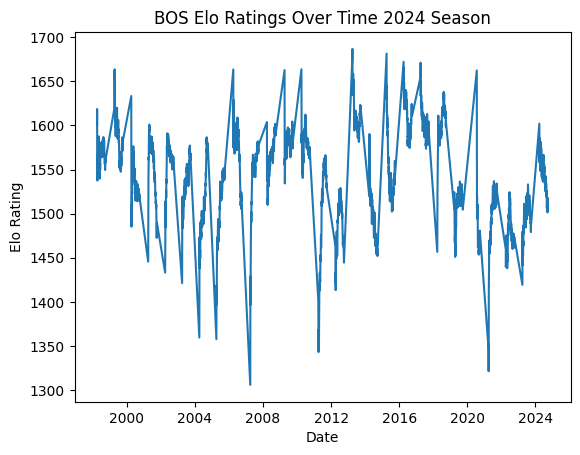

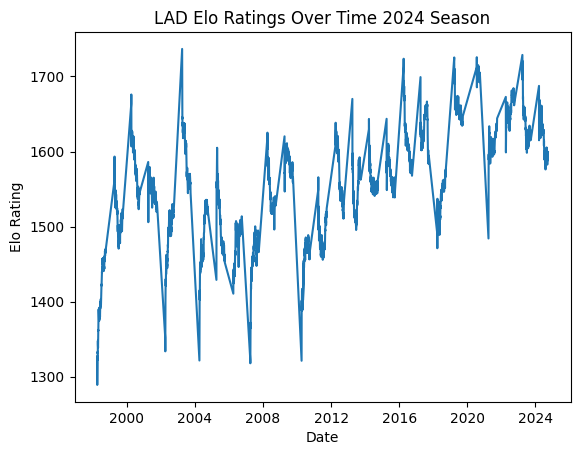

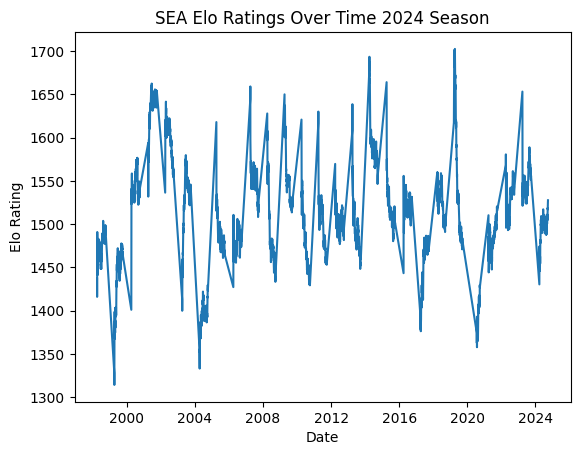

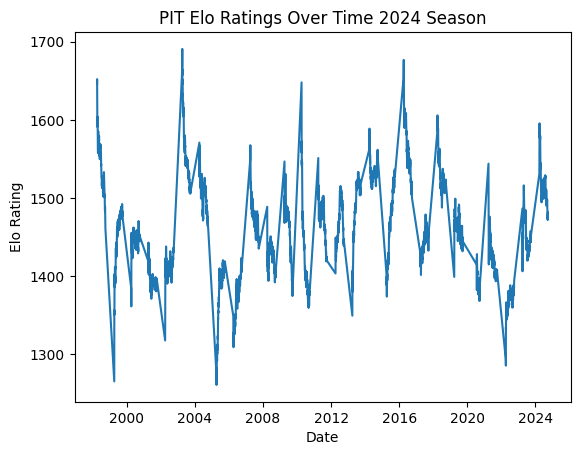

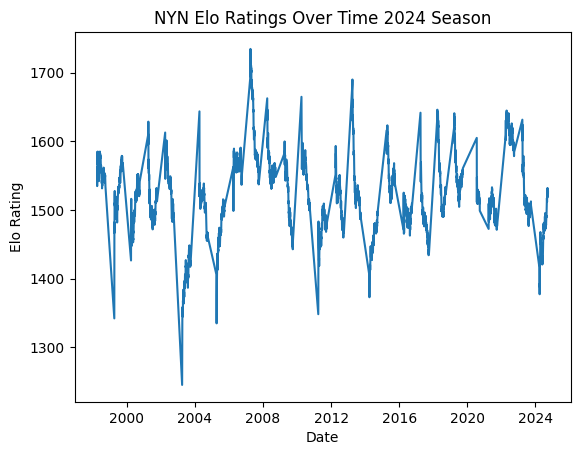

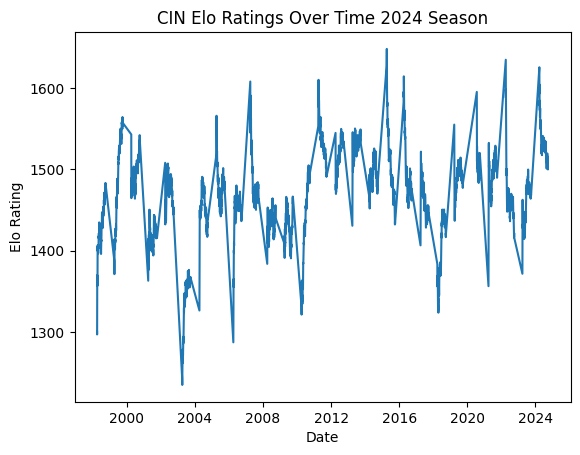

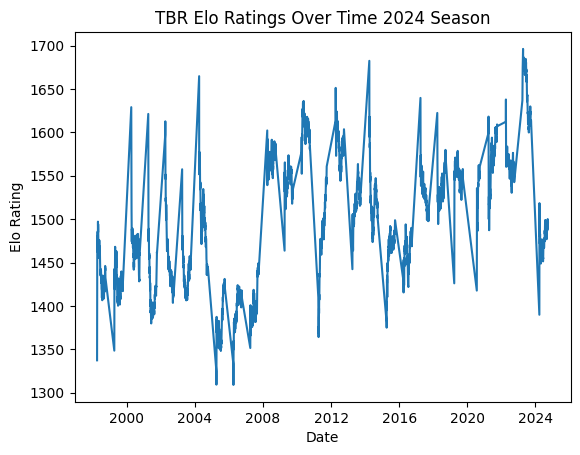

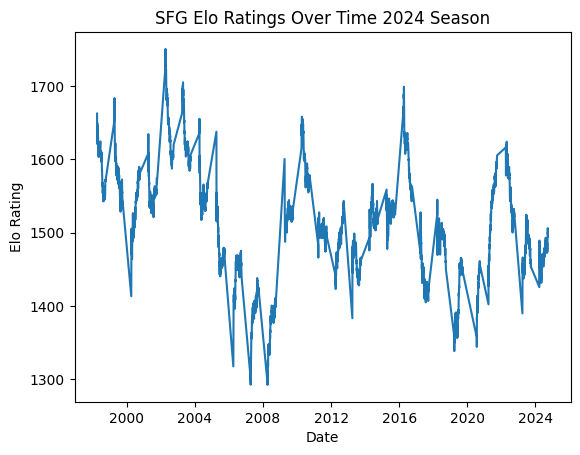

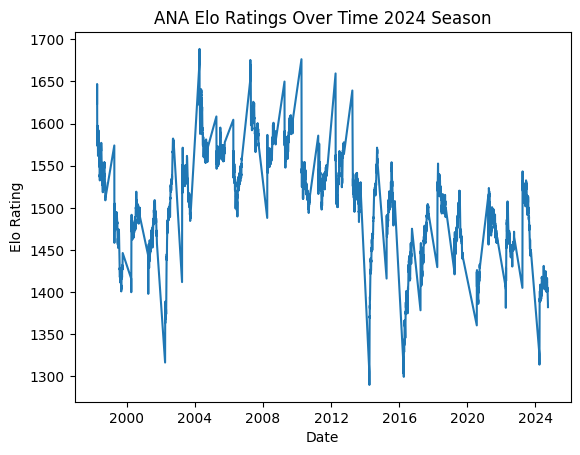

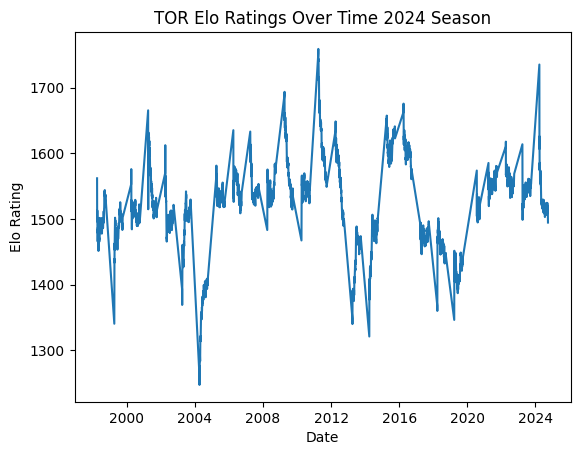

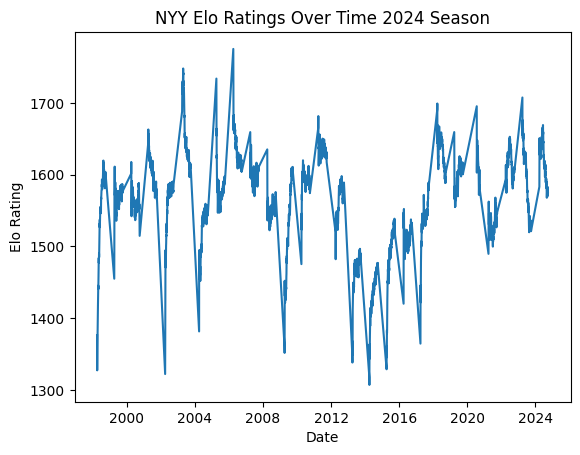

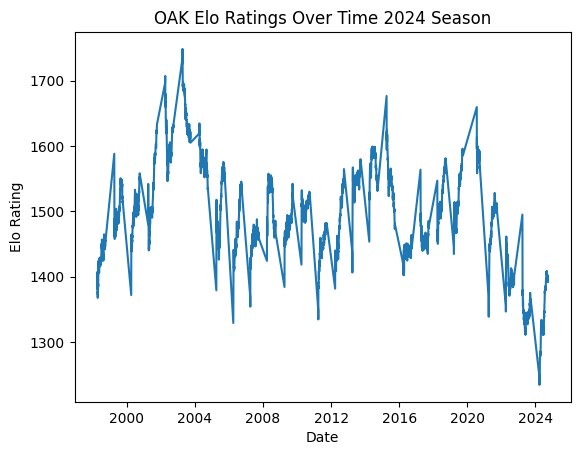

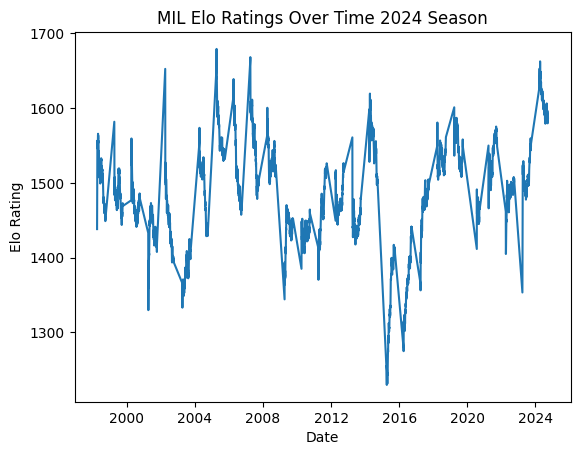

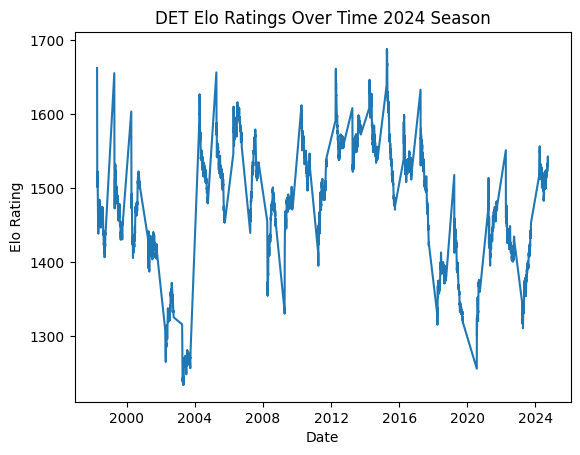

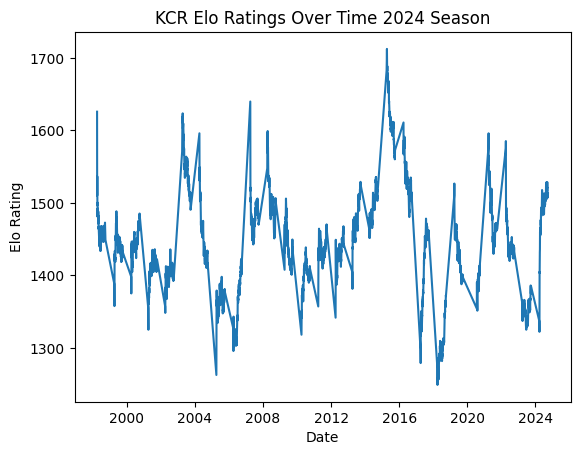

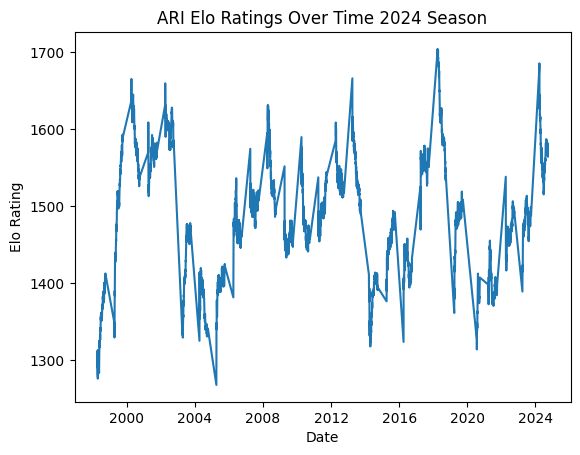

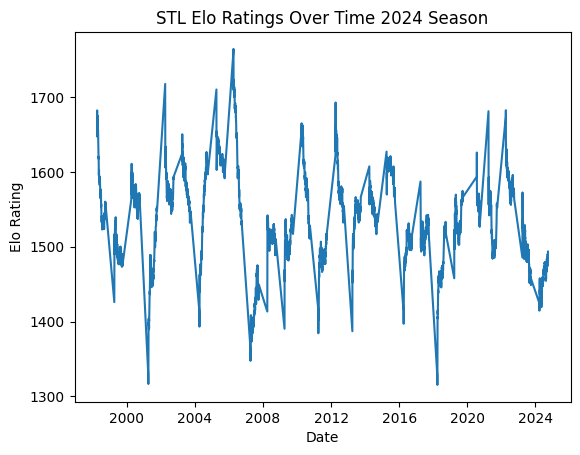

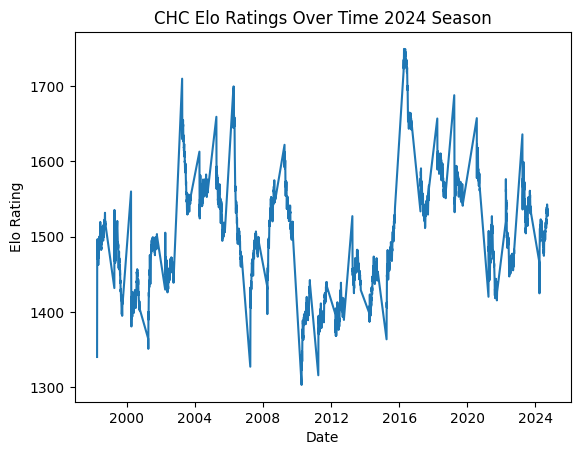

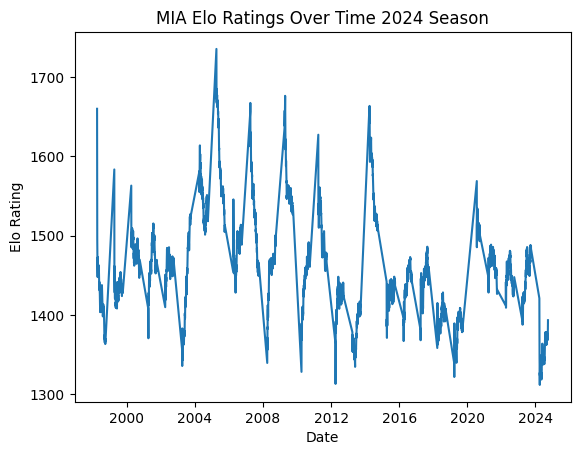

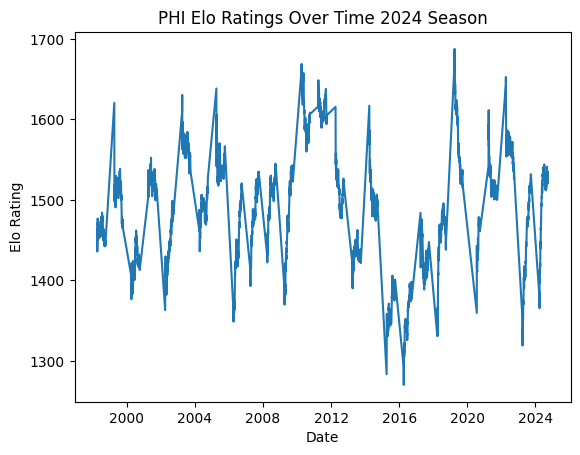

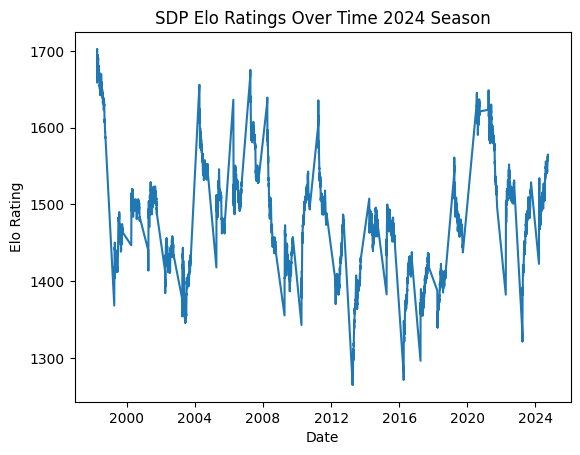

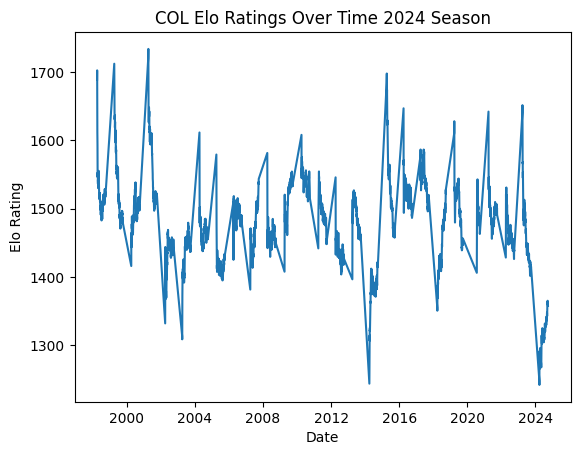

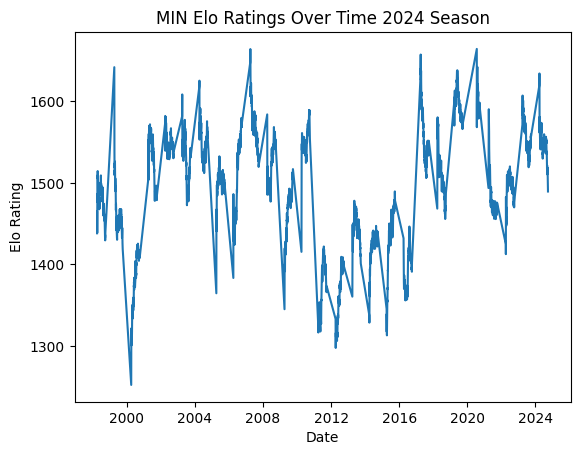

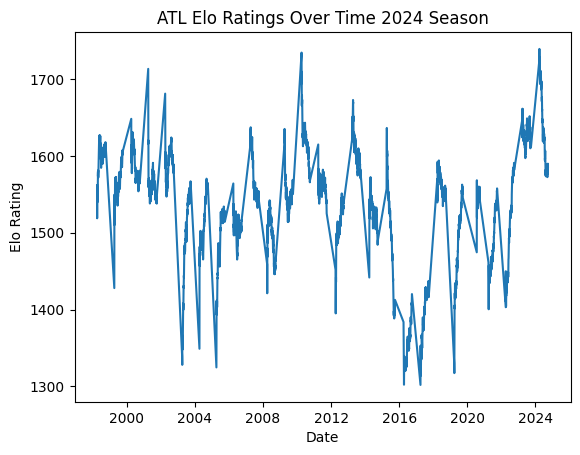

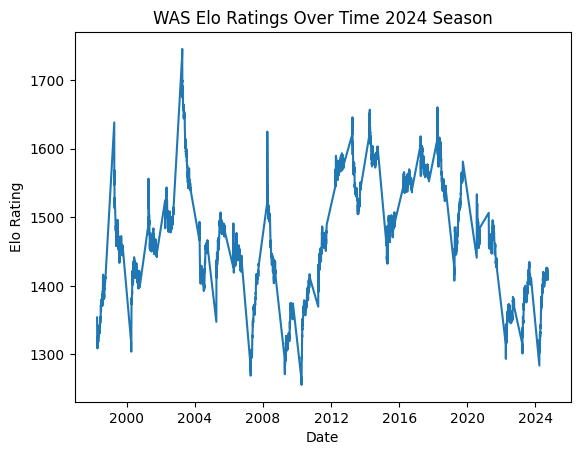

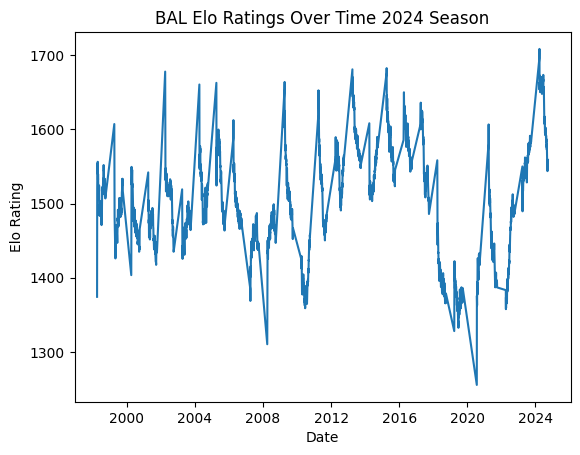

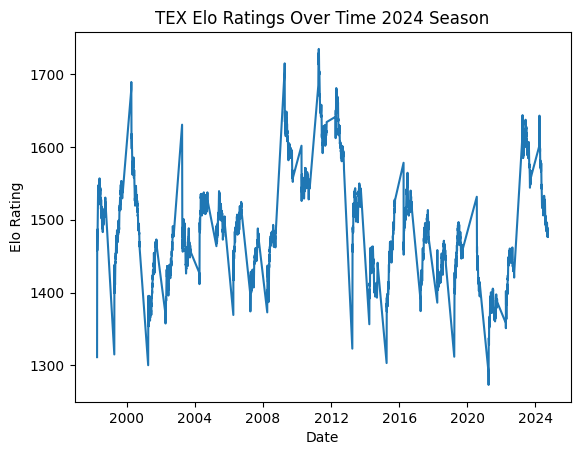

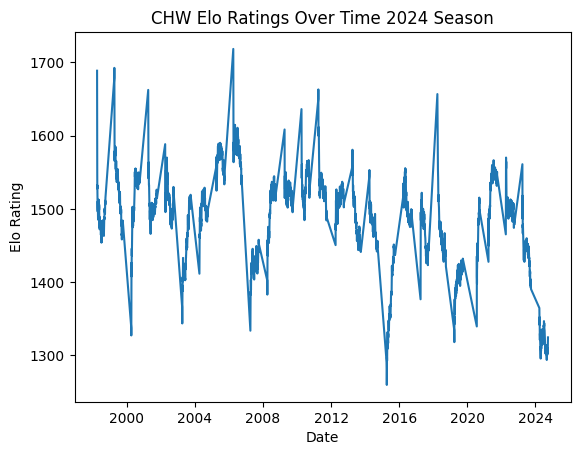

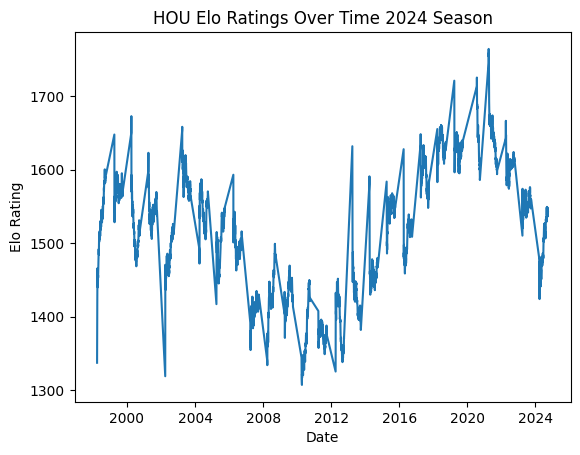

In [47]:
for team in teams:
    team_df = team_history_df.filter(pl.col("team") == team)
    plt.plot(
        team_df.select(pl.col("game_datetime")),
        team_df.select(pl.col("elo")),
        label=team,
    )
    plt.xlabel("Date")
    plt.ylabel("Elo Rating")
    plt.title(f"{team} Elo Ratings Over Time 2024 Season")
    plt.show()

In [48]:
winning_percentages = {}

In [49]:
for team in sorted(teams):
    played = games_played[team]
    played_total = played * 26 if played > 0 else 0
    won = games_won[team]
    pct = won / played_total if played_total > 0 else 0
    winning_percentages[team] = pct

In [50]:
# Print end of season Elo ratings for all teams
print("End of Timeframe Elo Ratings:")
print("-" * 30)
for team, elo in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
    print(f"{team}: {elo:.2f}, Winning Percentage: {winning_percentages[team]:.3f}")

End of Timeframe Elo Ratings:
------------------------------
LAD: 1599.35, Winning Percentage: 0.569
ATL: 1587.31, Winning Percentage: 0.561
MIL: 1586.86, Winning Percentage: 0.500
NYY: 1574.42, Winning Percentage: 0.593
ARI: 1570.06, Winning Percentage: 0.495
SDP: 1559.06, Winning Percentage: 0.489
BAL: 1558.86, Winning Percentage: 0.466
CLE: 1557.88, Winning Percentage: 0.533
HOU: 1542.36, Winning Percentage: 0.532
DET: 1530.73, Winning Percentage: 0.469
CHC: 1530.18, Winning Percentage: 0.505
SEA: 1527.71, Winning Percentage: 0.506
NYN: 1524.69, Winning Percentage: 0.513
PHI: 1523.09, Winning Percentage: 0.515
KCR: 1513.09, Winning Percentage: 0.445
BOS: 1509.00, Winning Percentage: 0.553
CIN: 1503.79, Winning Percentage: 0.483
TBR: 1496.41, Winning Percentage: 0.496
SFG: 1495.10, Winning Percentage: 0.529
TOR: 1494.44, Winning Percentage: 0.510
STL: 1493.43, Winning Percentage: 0.555
MIN: 1489.38, Winning Percentage: 0.503
TEX: 1485.40, Winning Percentage: 0.503
PIT: 1479.60, Winni

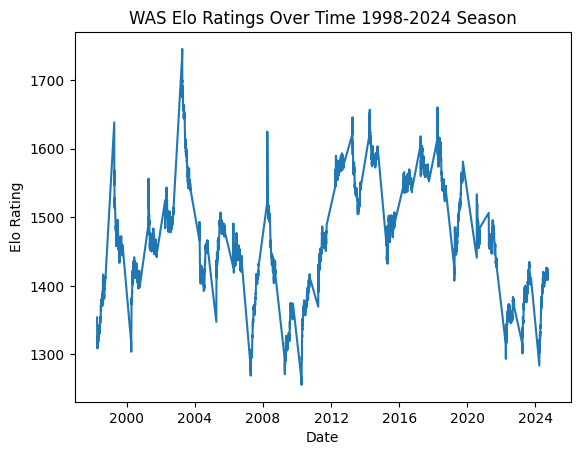

In [51]:
nats_df = team_history_df.filter(pl.col("team") == "WAS")
plt.plot(
    nats_df.select(pl.col("game_datetime")),
    nats_df.select(pl.col("elo")),
    label="WAS",
)
plt.xlabel("Date")
plt.ylabel("Elo Rating")
plt.title("WAS Elo Ratings Over Time 1998-2024 Season")
plt.show()